In [1]:
%load_ext autoreload
%autoreload 2
#import umap
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sns.set(font_scale=1.5, rc={'text.usetex' : False})
%config InlineBackend.figure_format = "png"
from scipy.interpolate import griddata
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
from common import *
import os
import glob
import re
from statistics import median, mean

In [2]:
gammas = np.arange(50, 205, 5, dtype=np.int32)
chromosome = 10
threshold = 0.05

# Calculate mean absolute difference of distances

$$ MD(d) = \frac{1}{n^2} \sum_i \sum_j |d_i - d_j| $$

In [3]:
alphas = [75, 108]

In [4]:
gammas = {}

gamma_ = re.compile(r".+gamma(\d+)_alpha")

for alpha in alphas:
    files = glob.glob(f"matlab/output/A1_chr{chromosome}_gamma*_alpha{alpha}_partitions.csv")
    gammas_ = [int(gamma_.match(file).group(1)) for file in files]
    gammas[alpha] = sorted(set(gammas_))

gammas

{75: [50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100,
  105,
  110,
  115,
  120,
  125,
  130,
  135,
  140,
  145,
  150,
  155,
  160,
  165,
  170,
  175,
  180,
  185,
  190,
  195,
  200],
 108: [50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100,
  105,
  110,
  115,
  120,
  125,
  130,
  135]}

In [59]:
md = {alpha: [] for alpha in alphas}

for alpha in alphas:
    for gamma in gammas[alpha]:
        filename = f"./matlab/output/A1_chr{chromosome}_gamma{gamma}_alpha{alpha}_partitions.csv"
        out_name = f"./output/A1_chr{chromosome}_threshold0.txt"
        command = f"./partition-validation/partition-validation -s 123 -t 0.00000001 {filename} {out_name}"
        os.system(command)
        df = pd.read_csv(f"./output/A1_chr{chromosome}_threshold0_distances.txt", sep=" ", comment="#")
        md[alpha].append(df.Distance.sum() / (df.ClusterId2.max() ** 2))

Version: Nov 5, 2022.
Command: ./partition-validation/partition-validation -s 123 -t 0.00000001 ./matlab/output/A1_chr10_gamma50_alpha75_partitions.csv ./output/A1_chr10_threshold0.txt
Setup:
--> Using seed: 123
--> Will cluster partitions such that no partition is farther away from its center than: 1e-08
--> Will read partitions from file: ./matlab/output/A1_chr10_gamma50_alpha75_partitions.csv
--> Will write clusters to file: ./output/A1_chr10_threshold0.txt
--> Will use number of threads: 1
Reading partitions file with 1000 partitions...of 1355 nodes...done!
Clustering 1000 partitions (modified algorithm):
--> Writing 963 clusters...done!
Version: Nov 5, 2022.
Command: ./partition-validation/partition-validation -s 123 -t 0.00000001 ./matlab/output/A1_chr10_gamma55_alpha75_partitions.csv ./output/A1_chr10_threshold0.txt
Setup:
--> Using seed: 123
--> Will cluster partitions such that no partition is farther away from its center than: 1e-08
--> Will read partitions from file: ./matla

In [20]:
df = pd.read_csv(f"matlab/output/A1_chr{chromosome}_gamma100_alpha108_partitions.csv", sep=" ", header=None)
df = df.apply(lambda x: x.value_counts())
#df
df.apply(lambda x: effective_size(x[~np.isnan(x)]), raw=True).mean() / 10

3.2740372712857906

In [61]:
data = []
for alpha in alphas:
    modularity = pd.read_csv(f"matlab/output/A1_chr{chromosome}_alpha{alpha}_modularity.csv", sep=" ", header=None).T
    for i, gamma in enumerate(gammas[alpha]):
        if gamma == 180:
            break
        q = modularity[i]

        df = pd.read_csv(f"matlab/output/A1_chr{chromosome}_gamma{gamma}_alpha{alpha}_partitions.csv", sep=" ", header=None)
        df = df.apply(lambda x: x.value_counts())
        df = df.apply(lambda x: effective_size(x[~np.isnan(x)]), raw=True)

        data.append({
            "$\\alpha$": str(alpha / 100),
            "$\gamma$": gamma / 100,
            "MD($d$)": md[alpha][i],
            "CV($Q$)": q.std() / q.mean(),
            'eff. community size (kb)': df.mean() * 100,
        })
df1 = pd.DataFrame(data)
df1.head()

,$\alpha$,$\gamma$,MD($d$),CV($Q$),eff. community size (kb)
0,0.75,0.50,0.107770,0.002827,35535.832086
1,0.75,0.55,0.134509,0.002487,26840.710597
2,0.75,0.60,0.166254,0.001848,19954.760163
3,0.75,0.65,0.198308,0.001461,12378.345654
4,0.75,0.70,0.192749,0.001112,8818.836040


In [62]:
df1["eff. community size (Mb)"] = df1["eff. community size (kb)"] / 1000

In [63]:
df1[df1["$\\alpha$"] == "0.75"]

,$\alpha$,$\gamma$,MD($d$),CV($Q$),eff. community size (kb),eff. community size (Mb)
0,0.75,0.50,0.107770,0.002827,35535.832086,35.535832
1,0.75,0.55,0.134509,0.002487,26840.710597,26.840711
2,0.75,0.60,0.166254,0.001848,19954.760163,19.954760
3,0.75,0.65,0.198308,0.001461,12378.345654,12.378346
4,0.75,0.70,0.192749,0.001112,8818.836040,8.818836
5,0.75,0.75,0.173323,0.000972,6114.470220,6.114470
6,0.75,0.80,0.160195,0.000995,5052.142069,5.052142
7,0.75,0.85,0.143621,0.000902,4234.329740,4.234330
8,0.75,0.90,0.132054,0.000878,3486.884768,3.486885
9,0.75,0.95,0.126099,0.000827,3094.014781,3.094015


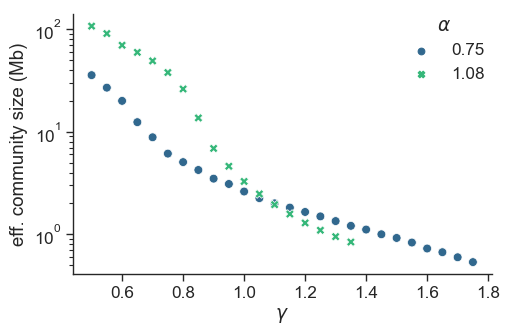

In [53]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)
p1 = sns.relplot(df1, x="$\gamma$", y="eff. community size (Mb)", style="$\\alpha$", hue="$\\alpha$", palette="viridis", s=40, height=3.5, aspect=1.5)
sns.move_legend(p1, "upper right", bbox_to_anchor=(0.85, 0.98))
plt.semilogy()
plt.savefig("results/gamma_eff_size.pdf", bbox_inches="tight")

In [65]:
df1[df1["$\\alpha$"] == "0.75"].corr()

,$\gamma$,MD($d$),CV($Q$),eff. community size (kb),eff. community size (Mb)
$\gamma$,1.000000,-0.875149,-0.783772,-0.728929,-0.728929
MD($d$),-0.875149,1.000000,0.561416,0.489613,0.489613
CV($Q$),-0.783772,0.561416,1.000000,0.991666,0.991666
eff. community size (kb),-0.728929,0.489613,0.991666,1.000000,1.000000
eff. community size (Mb),-0.728929,0.489613,0.991666,1.000000,1.000000


In [66]:
tad_eff_size = 3270
ab_sub_eff_size = 1102
ab_eff_size = 27387
ab_agg_eff_size = 66363

In [67]:
comp_df = pd.DataFrame([
    *[{"$\\alpha$": "A/B", "y": ab_agg_eff_size, 'MD($d$)': d} for d in [0, 0.42]],
    *[{"$\\alpha$": "A$_{1,2}$/B$_{1,2,3}$", "y": ab_eff_size, 'MD($d$)': d} for d in [0, 0.42]],
    *[{"$\\alpha$": "TAD", "y": tad_eff_size, 'MD($d$)': d} for d in [0, 0.42]],
])

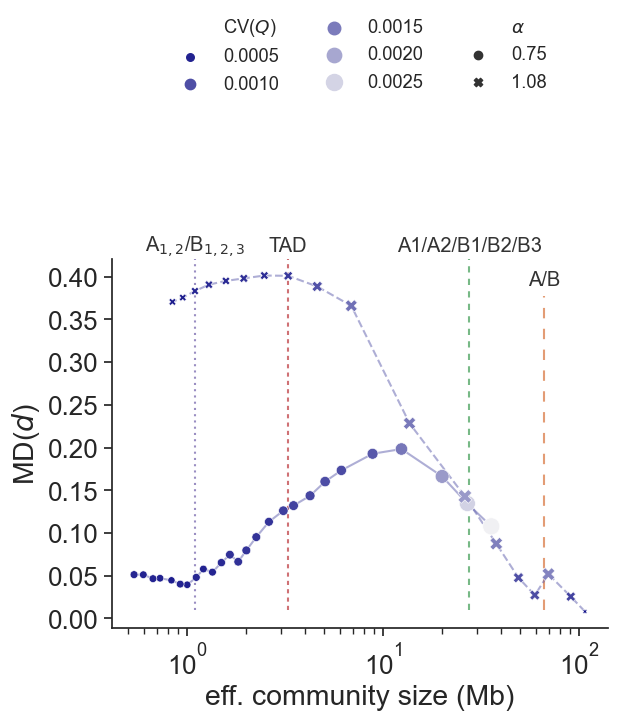

In [74]:
ax = plt.subplot()
sns.set(style="ticks", font_scale=1.2)
plt.grid(False)
sns.despine()
palette = sns.light_palette("navy", reverse=True, as_cmap=True)

ax.plot(df1[df1["$\\alpha$"] == "0.75"]["eff. community size (Mb)"], df1[df1["$\\alpha$"] == "0.75"]["MD($d$)"], zorder=1, alpha=0.5, c=palette(100))
ax.plot(df1[df1["$\\alpha$"] == "1.08"]["eff. community size (Mb)"], df1[df1["$\\alpha$"] == "1.08"]["MD($d$)"], zorder=1, alpha=0.5, c=palette(100), linestyle="--")

sns.scatterplot(df1,
                palette=palette,
                x="eff. community size (Mb)",
                y="MD($d$)",
                size="CV($Q$)",
                sizes=(10, 150),
                hue="CV($Q$)",
                style="$\\alpha$",
                ax=ax)
plt.semilogx()

cmap = sns.color_palette(as_cmap=True)

plt.axvline(ab_agg_eff_size / 1000, 0.05, 0.90, c=cmap[1], dashes=[5, 5], zorder=0, alpha=0.8)
plt.text(ab_agg_eff_size / 1000, 0.39, "A/B", c="#333", horizontalalignment="center")

plt.axvline(ab_eff_size / 1000, 0.05, 1, c=cmap[2], dashes=[3, 3], zorder=0, alpha=0.8)
plt.text(ab_eff_size / 1000, 0.43, "A1/A2/B1/B2/B3", c="#333", horizontalalignment="center")

plt.axvline(tad_eff_size / 1000, 0.05, 1, c=cmap[3], dashes=[2, 2], zorder=0, alpha=0.8)
plt.text(tad_eff_size / 1000, 0.43, "TAD", c="#333", horizontalalignment="center")

plt.axvline(ab_sub_eff_size / 1000, 0.05, 1, c=cmap[4], dashes=[1, 2], zorder=0, alpha=0.8)
plt.text(ab_sub_eff_size / 1000, 0.43, "A$_{1,2}$/B$_{1,2,3}$", c="#333", horizontalalignment="center")

sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, 1.7), ncol=3, frameon=False)

plt.savefig("results/md_eff_size.pdf", dpi=600, bbox_inches="tight")
plt.savefig("results/md_eff_size.png", dpi=600, bbox_inches="tight")

In [90]:
df1[df1["$\\alpha$"] == "0.75"]

,$\alpha$,$\gamma$,MD($d$),CV($Q$),eff. community size (kb),eff. community size (Mb)
0,0.75,0.50,0.107770,0.002827,35535.832086,35.535832
1,0.75,0.55,0.134509,0.002487,26840.710597,26.840711
2,0.75,0.60,0.166254,0.001848,19954.760163,19.954760
3,0.75,0.65,0.198308,0.001461,12378.345654,12.378346
4,0.75,0.70,0.192749,0.001112,8818.836040,8.818836
5,0.75,0.75,0.173323,0.000972,6114.470220,6.114470
6,0.75,0.80,0.160195,0.000995,5052.142069,5.052142
7,0.75,0.85,0.143621,0.000902,4234.329740,4.234330
8,0.75,0.90,0.132054,0.000878,3486.884768,3.486885
9,0.75,0.95,0.126099,0.000827,3094.014781,3.094015


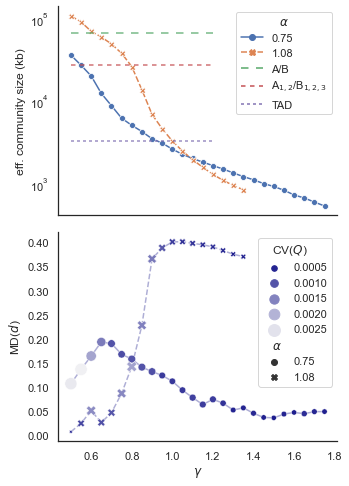

In [70]:
palette = sns.light_palette("navy", reverse=True, as_cmap=True)
fig, axs = plt.subplots(nrows=2, figsize=(5, 8), sharex=True)
sns.despine()
sns.set_style("white")
plt.grid(False)

axs[1].plot(df1[df1["$\\alpha$"] == "0.75"]["$\gamma$"], df1[df1["$\\alpha$"] == "0.75"]["MD($d$)"], zorder=1, alpha=0.5, c=palette(100))
axs[1].plot(df1[df1["$\\alpha$"] == "1.08"]["$\gamma$"], df1[df1["$\\alpha$"] == "1.08"]["MD($d$)"], zorder=1, alpha=0.5, c=palette(100), linestyle="--")

sns.scatterplot(df1,
                ax=axs[1],
            #kind="scatter",
            x="$\gamma$",
            y="MD($d$)",
            markers=True,
            size="CV($Q$)",
            sizes=(10, 150),
            hue="CV($Q$)",
            style="$\\alpha$",
            palette=palette)


g = sns.lineplot(data=df1,
                 ax=axs[0],
                 markers=True,
                 x="$\gamma$",
                 y="eff. community size (kb)",
                 style="$\\alpha$",
                 hue="$\\alpha$")
g.set(yscale='log')

sns.lineplot(comp_df,
             ax=axs[0],
             x="$\gamma$",
             y="y",
             palette=sns.color_palette(as_cmap=True)[2:],
             dashes=[[5, 5], [3, 3], [2, 2]],
             style="$\\alpha$",
             hue="$\\alpha$",
             alpha=0.8)

plt.subplots_adjust(hspace=0.08)

#plt.savefig("results/mean_diff_eff_size_chr10.png", dpi=600, bbox_inches="tight")
plt.savefig("results/mean_diff_eff_size_chr10.pdf", bbox_inches="tight")

# Heatmaps

In [53]:
gammas = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135]

In [54]:
files = glob.glob(f"matlab/output/A1_chr{chromosome}_gamma*_alpha*_partitions.csv")
alpha = re.compile(r".+alpha(.+)_partitions.+")
alphas = sorted(set([alpha.match(file).group(1) for file in files]), key=float)
alphas

['0',
 '10',
 '20',
 '30',
 '40',
 '50',
 '60',
 '70',
 '75',
 '78.6667',
 '82.3333',
 '86',
 '89.6667',
 '93.3333',
 '97',
 '100.6667',
 '104.3333',
 '108']

In [55]:
alphas = [alpha for alpha in alphas if float(alpha) > 70]
alphas

['75',
 '78.6667',
 '82.3333',
 '86',
 '89.6667',
 '93.3333',
 '97',
 '100.6667',
 '104.3333',
 '108']

In [56]:
data = []

for y, alpha in enumerate(alphas):
    for x, gamma in enumerate(gammas):
        df = pd.read_csv(f"matlab/output/A1_chr{chromosome}_gamma{gamma}_alpha{alpha}_partitions.csv", sep=" ", header=None)
        df = df.apply(lambda x: x.value_counts())
        df = df.apply(lambda x: effective_size(x[~np.isnan(x)]), raw=True)
        mean_size = df.mean() * 100

        filename = f"./matlab/output/A1_chr{chromosome}_gamma{gamma}_alpha{alpha}_partitions.csv"
        out_name = f"./output/A1_chr{chromosome}_threshold0.txt"
        command = f"./partition-validation/partition-validation -s 123 -t 0.00000001 {filename} {out_name}"
        os.system(command)
        df = pd.read_csv(f"./output/A1_chr{chromosome}_threshold0_distances.txt", sep=" ", comment="#")
        #md_all[alpha].append(df.Distance.sum() / (df.ClusterId2.max() ** 2))

        data.append({
            '$\\alpha$': str(float(alpha)/100),
            '$\gamma$': int(gamma)/100,
            'eff. community size (kb)': mean_size,
            'MD($d$)': df.Distance.sum() / (df.ClusterId2.max() ** 2),
            'x': x,
            'y': y,
        })

eff = pd.DataFrame(data)
eff.head()

Version: Feb 23, 2022.
Command: ./partition-validation/partition-validation -s 123 -t 0.00000001 ./matlab/output/A1_chr10_gamma50_alpha75_partitions.csv ./output/A1_chr10_threshold0.txt
Setup:
--> Using seed: 123
--> Will cluster partitions such that no partition is farther away from its center than: 1e-08
--> Will read partitions from file: ./matlab/output/A1_chr10_gamma50_alpha75_partitions.csv
--> Will write clusters to file: ./output/A1_chr10_threshold0.txt
--> Will use number of threads: 1
Reading partitions file with 1000 partitions...of 1355 nodes...done!
Clustering 1000 partitions:
--> Writing 963 clusters...done!
Version: Feb 23, 2022.
Command: ./partition-validation/partition-validation -s 123 -t 0.00000001 ./matlab/output/A1_chr10_gamma55_alpha75_partitions.csv ./output/A1_chr10_threshold0.txt
Setup:
--> Using seed: 123
--> Will cluster partitions such that no partition is farther away from its center than: 1e-08
--> Will read partitions from file: ./matlab/output/A1_chr10_g

,$\alpha$,$\gamma$,eff. community size (kb),MD($d$),x,y
0,0.75,0.50,35535.832086,0.107770,0,0
1,0.75,0.55,26840.710597,0.134509,1,0
2,0.75,0.60,19954.760163,0.166254,2,0
3,0.75,0.65,12378.345654,0.198308,3,0
4,0.75,0.70,8818.836040,0.192749,4,0


In [57]:
bins = pd.cut(eff["eff. community size (kb)"], bins=np.logspace(3, 5, 15))
eff["bin"] = bins
eff.head()

,$\alpha$,$\gamma$,eff. community size (kb),MD($d$),x,y,bin
0,0.75,0.50,35535.832086,0.107770,0,0,"(26826.958, 37275.937]"
1,0.75,0.55,26840.710597,0.134509,1,0,"(26826.958, 37275.937]"
2,0.75,0.60,19954.760163,0.166254,2,0,"(19306.977, 26826.958]"
3,0.75,0.65,12378.345654,0.198308,3,0,"(10000.0, 13894.955]"
4,0.75,0.70,8818.836040,0.192749,4,0,"(7196.857, 10000.0]"


In [58]:
eff.corr(method="spearman")

,$\gamma$,eff. community size (kb),MD($d$),x,y
$\gamma$,1.000000,-0.975555,0.456432,1.000000,0.000000
eff. community size (kb),-0.975555,1.000000,-0.523965,-0.975555,0.087365
MD($d$),0.456432,-0.523965,1.000000,0.456432,0.366509
x,1.000000,-0.975555,0.456432,1.000000,0.000000
y,0.000000,0.087365,0.366509,0.000000,1.000000


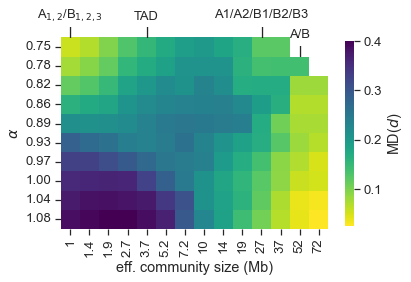

In [89]:
eff_table = eff.pivot_table(index="$\\alpha$", columns="bin", values="MD($d$)", aggfunc="mean")

ax = sns.heatmap(eff_table.interpolate(axis=1, limit=1),
                 cmap="viridis_r", square=True,
            xticklabels=[f"{(a.left / 1000):.2g}" for a in eff_table.columns],
            yticklabels=[f"{a:.4}" for a in eff_table.index],
            cbar_kws={"shrink": 0.85, "label": "MD($d$)"})

plt.xlabel("eff. community size (kb)")

plt.text(0.5, -1, "A$_{1,2}$/B$_{1,2,3}$", horizontalalignment="center", fontsize=13)
plt.text(0.5, 0, "l", horizontalalignment="center")

plt.text(4.5, -0.9, "TAD", horizontalalignment="center", fontsize=13)
plt.text(4.5, 0, "l", horizontalalignment="center")

plt.text(10.5, -1, "A1/A2/B1/B2/B3", horizontalalignment="center", fontsize=13)
plt.text(10.5, 0, "l", horizontalalignment="center")

plt.text(12.5, 0, "A/B", horizontalalignment="center", fontsize=13)
plt.text(12.5, 1, "l", horizontalalignment="center")

plt.xticks(rotation=90)

plt.xlabel("eff. community size (Mb)")

plt.savefig("results/alpha_eff_size_md.png", dpi=600, bbox_inches="tight")
plt.savefig("results/alpha_eff_size_md.pdf", dpi=600, bbox_inches="tight")

In [433]:
ab_agg_eff_size

66363

In [371]:
md_matrix = np.zeros((len(alphas), len(gammas)))
for i, alpha in enumerate(alphas):
    for j, gamma in enumerate(gammas):
        md_matrix[i,j] = md_all[alpha][j]

In [372]:
q_matrix = np.zeros((len(alphas), len(gammas)))
for i, alpha in enumerate(alphas):
    df = pd.read_csv(f"matlab/output/A1_chr{chromosome}_alpha{alpha}_modularity.csv", sep=" ", header=None).T
    for j, gamma in enumerate(gammas):
        q_matrix[i,j] = df[j].std() / df[j].mean()

In [68]:
eff_matrix = np.zeros((len(alphas), len(gammas)))
for i, alpha in enumerate(alphas):
    rows = eff[eff["$\\alpha$"] == str(float(alpha)/100)]
    for j, gamma in enumerate(gammas):
        rows_ = rows[rows["$\gamma$"] == gamma/100]
        eff_matrix[i, j] = rows_["eff. community size (kb)"]

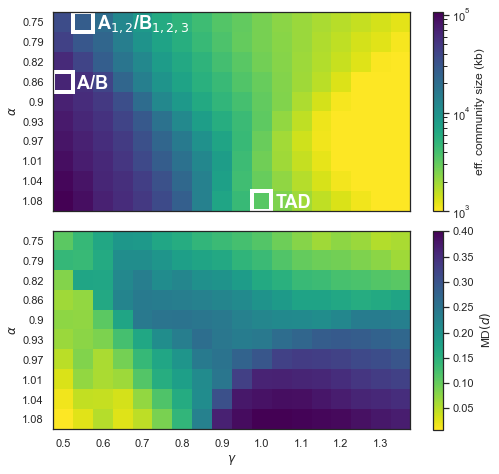

In [635]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

fig, (ax3, ax1) = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)
im1 = ax1.imshow(md_matrix, cmap="viridis_r")
ax1.set_ylabel("$\\alpha$")
ax1.set_xlabel("$\gamma$")
#ax1.set_xticks(range(len(gammas)), [gamma/100 for gamma in gammas])
ax1.set_yticks(list(range(len(alphas))), [round(float(alpha)/100, 2) for alpha in alphas])
ax1.grid(False)
cbar = plt.colorbar(im1, shrink=0.92, ax=ax1)
cbar.set_label("MD$(d)$")

#ax2.imshow(q_matrix, cmap="viridis_r")
#ax2.set_ylabel("$\\alpha$")
#ax2.set_xlabel("$\gamma$")
#ax2.set_xticks(range(len(gammas)), [gamma/100 for gamma in gammas])
#ax2.set_yticks(list(range(len(alphas))), [round(float(alpha)/100, 2) for alpha in alphas])
#ax2.grid(False)

im3 = ax3.imshow(eff_matrix, cmap="viridis_r", norm=LogNorm(vmin=1000, vmax=eff["eff. community size (kb)"].max()))

idx = np.argmin(np.abs(eff_matrix - tad_eff_size))
pos = np.unravel_index(idx, eff_matrix.shape)
y, x = pos[0], pos[1]
rect = Rectangle((x - 0.5, y - 0.5), 1, 1, edgecolor="w", fill=False, linewidth=4)
ax3.add_patch(rect)
ax3.text(x + 0.7, y + 0.35, "TAD", color="w", fontsize=18, fontweight="bold")

idx = np.argmin(np.abs(eff_matrix - ab_eff_size))
pos = np.unravel_index(idx, eff_matrix.shape)
y, x = pos[0], pos[1]
rect = Rectangle((x - 0.5, y - 0.5), 1, 1, edgecolor="w", fill=False, linewidth=4)
ax3.add_patch(rect)
ax3.text(x + 0.7, y + 0.35, "A$_{1,2}$/B$_{1,2,3}$", color="w", fontsize=18, fontweight="bold")

idx = np.argmin(np.abs(eff_matrix - ab_agg_eff_size))
pos = np.unravel_index(idx, eff_matrix.shape)
y, x = pos[0], pos[1]
rect = Rectangle((x - 0.5, y - 0.5), 1, 1, edgecolor="w", fill=False, linewidth=4, alpha=1)
ax3.add_patch(rect)
ax3.text(x + 0.7, y + 0.35, "A/B", color="w", fontsize=18, fontweight="bold")

ax3.set_ylabel("$\\alpha$")
ax3.set_xticks(range(0, len(gammas), 2), [gamma/100 for gamma in gammas[0::2]])
ax3.set_yticks(list(range(0, len(alphas))), [round(float(alpha)/100, 2) for alpha in alphas])
ax3.grid(False)
cbar = plt.colorbar(im3, shrink=0.92, ax=ax3)
cbar.set_label("eff. community size (kb)")

plt.subplots_adjust(hspace=0.01)

plt.savefig("results/eff_md_heatmaps.png", dpi=600, bbox_inches="tight")

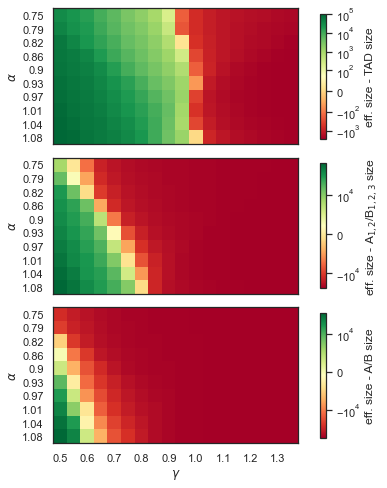

In [69]:
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.patches import Rectangle

fig, (ax3, ax2, ax1) = plt.subplots(nrows=3, figsize=(8, 8), sharex=True)

mat = eff_matrix - tad_eff_size
im3 = ax3.imshow(mat, cmap="RdYlGn", norm=SymLogNorm(linthresh=100))
ax3.set_ylabel("$\\alpha$")
#ax3.set_xlabel("$\gamma$")
ax3.set_xticks(range(0, len(gammas), 2), [gamma/100 for gamma in gammas[0::2]])
ax3.set_yticks(list(range(0, len(alphas))), [round(float(alpha)/100, 2) for alpha in alphas])
ax3.grid(False)
cbar = plt.colorbar(im3, shrink=0.92, ax=ax3)
cbar.set_label("eff. size - TAD size")

mat = eff_matrix - ab_eff_size
im1 = ax2.imshow(mat, cmap="RdYlGn", norm=SymLogNorm(linthresh=10000))
ax2.set_ylabel("$\\alpha$")
#ax2.set_xlabel("$\gamma$")
ax2.set_xticks(range(0, len(gammas), 2), [gamma/100 for gamma in gammas[0::2]])
ax2.set_yticks(list(range(0, len(alphas))), [round(float(alpha)/100, 2) for alpha in alphas])
ax2.grid(False)
cbar = plt.colorbar(im1, shrink=0.92, ax=ax2)
cbar.set_label("eff. size - A$_{1,2}$/B$_{1,2,3}$ size")

mat = eff_matrix - ab_agg_eff_size
im1 = ax1.imshow(mat, cmap="RdYlGn", norm=SymLogNorm(linthresh=10000))
ax1.set_ylabel("$\\alpha$")
ax1.set_xlabel("$\gamma$")
ax1.set_xticks(range(0, len(gammas), 2), [gamma/100 for gamma in gammas[0::2]])
ax1.set_yticks(list(range(0, len(alphas))), [round(float(alpha)/100, 2) for alpha in alphas])
ax1.grid(False)
cbar = plt.colorbar(im1, shrink=0.92, ax=ax1)
cbar.set_label("eff. size - A/B size")

plt.subplots_adjust(hspace=0.1)

plt.savefig("results/heatmaps_diff.png", dpi=600, bbox_inches="tight")